In [13]:
!pip install transformers datasets soundfile speechbrain accelerate
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 14.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: ruamel.yaml
    Found existing installation: ruamel.yaml 0.17.32
    Uninstalling ruamel.yaml-0.17.32:
      Successfully uninstalled ruamel.yaml-0.17.32
^C
ERROR: Operation cancelled by user


In [15]:
!wget https://openslr.org/resources/44/su_id_male.zip

--2023-08-28 13:00:49--  https://openslr.org/resources/44/su_id_male.zip
Resolving openslr.org (openslr.org)... 46.101.158.64
Connecting to openslr.org (openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://us.openslr.org/resources/44/su_id_male.zip [following]
--2023-08-28 13:00:49--  http://us.openslr.org/resources/44/su_id_male.zip
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 610827081 (583M) [application/zip]
Saving to: ‘su_id_male.zip.1’

su_id_male.zip.1    100%[===================>] 582.53M  24.6MB/s    in 25s     

2023-08-28 13:01:15 (23.0 MB/s) - ‘su_id_male.zip.1’ saved [610827081/610827081]



In [16]:
!unzip /kaggle/working/su_id_male.zip

Archive:  /kaggle/working/su_id_male.zip
   creating: su_id_male/
  inflating: su_id_male/line_index.tsv  
   creating: su_id_male/wavs/
  inflating: su_id_male/wavs/sum_01552_00419200389.wav  
  inflating: su_id_male/wavs/sum_01552_00415777817.wav  
  inflating: su_id_male/wavs/sum_01552_00397471866.wav  
  inflating: su_id_male/wavs/sum_01552_00390025903.wav  
  inflating: su_id_male/wavs/sum_01552_00322797200.wav  
  inflating: su_id_male/wavs/sum_01552_00268508864.wav  
  inflating: su_id_male/wavs/sum_01596_00278806399.wav  
  inflating: su_id_male/wavs/sum_01552_00249362669.wav  
  inflating: su_id_male/wavs/sum_01552_00196453261.wav  
  inflating: su_id_male/wavs/sum_01552_00191935649.wav  
  inflating: su_id_male/wavs/sum_01552_00145075922.wav  
  inflating: su_id_male/wavs/sum_01552_00061462910.wav  
  inflating: su_id_male/wavs/sum_01038_02075137379.wav  
  inflating: su_id_male/wavs/sum_01038_02059844406.wav  
  inflating: su_id_male/wavs/sum_01038_02013441576.wav  
  inflat

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import torch
import torchaudio
import pandas as pd
import datasets
import librosa

from functools import partial
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from speechbrain.pretrained import EncoderClassifier
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from huggingface_hub import notebook_login
from datasets import Dataset
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, Seq2SeqTrainingArguments, Seq2SeqTrainer, SpeechT5HifiGan
sns.set()

In [18]:
notebook_login()

In [19]:
data = pd.read_csv("/kaggle/working/su_id_male/line_index.tsv", names=["path_wav", "kosong_2", "text"], sep="\t")
data

,path_wav,kosong_2,text
0,sum_00060_00010202907,NaN,saur muhamad farhan kagiatan rebo nyunda mangr...
1,sum_00060_00023142156,NaN,kompleks perumahan anu caket sasana budaya gan...
2,sum_00060_00042028548,NaN,rumaja ngarumpul di bangor
3,sum_00060_00053040767,NaN,bangsa manuk digolongkeun dina kelas aves
4,sum_00060_00087177826,NaN,surat ieu dingaranan oge iqro atawa al kolam
...,...,...,...
1807,sum_09757_02045064943,NaN,dina bulan sawal taun dua rebu salapan seueur ...
1808,sum_09757_02048217234,NaN,kompleks perumahan anu caket situ cangkuang ag...
1809,sum_09757_02068107378,NaN,narkoba sok disalahgunakeun ku jelma nu teu bener
1810,sum_09757_02087979756,NaN,turis mancanagara keur ningali gerhana bulan p...


In [20]:
data.drop(["kosong_2"], axis=1, inplace=True)
data

,path_wav,text
0,sum_00060_00010202907,saur muhamad farhan kagiatan rebo nyunda mangr...
1,sum_00060_00023142156,kompleks perumahan anu caket sasana budaya gan...
2,sum_00060_00042028548,rumaja ngarumpul di bangor
3,sum_00060_00053040767,bangsa manuk digolongkeun dina kelas aves
4,sum_00060_00087177826,surat ieu dingaranan oge iqro atawa al kolam
...,...,...
1807,sum_09757_02045064943,dina bulan sawal taun dua rebu salapan seueur ...
1808,sum_09757_02048217234,kompleks perumahan anu caket situ cangkuang ag...
1809,sum_09757_02068107378,narkoba sok disalahgunakeun ku jelma nu teu bener
1810,sum_09757_02087979756,turis mancanagara keur ningali gerhana bulan p...


In [21]:
data["path_wav"] = "/kaggle/working/su_id_male/wavs/" + data["path_wav"] + ".wav"
data

,path_wav,text
0,/kaggle/working/su_id_male/wavs/sum_00060_0001...,saur muhamad farhan kagiatan rebo nyunda mangr...
1,/kaggle/working/su_id_male/wavs/sum_00060_0002...,kompleks perumahan anu caket sasana budaya gan...
2,/kaggle/working/su_id_male/wavs/sum_00060_0004...,rumaja ngarumpul di bangor
3,/kaggle/working/su_id_male/wavs/sum_00060_0005...,bangsa manuk digolongkeun dina kelas aves
4,/kaggle/working/su_id_male/wavs/sum_00060_0008...,surat ieu dingaranan oge iqro atawa al kolam
...,...,...
1807,/kaggle/working/su_id_male/wavs/sum_09757_0204...,dina bulan sawal taun dua rebu salapan seueur ...
1808,/kaggle/working/su_id_male/wavs/sum_09757_0204...,kompleks perumahan anu caket situ cangkuang ag...
1809,/kaggle/working/su_id_male/wavs/sum_09757_0206...,narkoba sok disalahgunakeun ku jelma nu teu bener
1810,/kaggle/working/su_id_male/wavs/sum_09757_0208...,turis mancanagara keur ningali gerhana bulan p...


In [22]:
def array(batch):
    array, _ = librosa.load(batch, sr=16000)
    return array

def sample_rate(batch):
    _, sample_rate = librosa.load(batch, sr=16000)
    return sample_rate

In [23]:
data["array"] = data["path_wav"].map(array)
data["sample_rate"] = data["path_wav"].map(sample_rate)
data

,path_wav,text,array,sample_rate
0,/kaggle/working/su_id_male/wavs/sum_00060_0001...,saur muhamad farhan kagiatan rebo nyunda mangr...,"[2.5098894e-05, -0.0002056821, -0.00016244123,...",16000
1,/kaggle/working/su_id_male/wavs/sum_00060_0002...,kompleks perumahan anu caket sasana budaya gan...,"[0.000127055, 0.00043004454, 0.00067124923, 0....",16000
2,/kaggle/working/su_id_male/wavs/sum_00060_0004...,rumaja ngarumpul di bangor,"[-5.0915794e-05, -0.00016755088, -0.0001009354...",16000
3,/kaggle/working/su_id_male/wavs/sum_00060_0005...,bangsa manuk digolongkeun dina kelas aves,"[8.443345e-06, 0.00020494306, 0.000115291725, ...",16000
4,/kaggle/working/su_id_male/wavs/sum_00060_0008...,surat ieu dingaranan oge iqro atawa al kolam,"[1.0072752e-05, 6.830295e-05, 0.00019736204, -...",16000
...,...,...,...,...
1807,/kaggle/working/su_id_male/wavs/sum_09757_0204...,dina bulan sawal taun dua rebu salapan seueur ...,"[-4.75912e-06, 2.2946959e-05, 3.860156e-05, -6...",16000
1808,/kaggle/working/su_id_male/wavs/sum_09757_0204...,kompleks perumahan anu caket situ cangkuang ag...,"[1.2945242e-05, -1.3669287e-06, 1.0990403e-05,...",16000
1809,/kaggle/working/su_id_male/wavs/sum_09757_0206...,narkoba sok disalahgunakeun ku jelma nu teu bener,"[-5.5247107e-05, -0.00016928223, -6.919468e-05...",16000
1810,/kaggle/working/su_id_male/wavs/sum_09757_0208...,turis mancanagara keur ningali gerhana bulan p...,"[-0.000101387195, -9.202949e-05, -0.0001851124...",16000


In [24]:
data["array"][0]

array([ 2.5098894e-05, -2.0568210e-04, -1.6244123e-04, ...,
        1.6684420e-04,  3.8979906e-06,  6.8195302e-05], dtype=float32)

In [25]:
for x in range(0, 10):
    print(len(data["array"][x]))

91732
65837
31109
42943
51392
40281
36121
56466
41247
61469


In [26]:
for a in data["array"][:5]:
    print(a)

[ 2.5098894e-05 -2.0568210e-04 -1.6244123e-04 ...  1.6684420e-04
  3.8979906e-06  6.8195302e-05]
[1.2705500e-04 4.3004454e-04 6.7124923e-04 ... 1.8858735e-04 7.1142684e-05
 9.7973767e-05]
[-5.09157944e-05 -1.67550883e-04 -1.00935446e-04 ... -1.21831261e-04
 -3.82471735e-05 -5.70390876e-05]
[ 8.44334500e-06  2.04943062e-04  1.15291725e-04 ...  7.21746765e-05
 -9.48272354e-05 -9.55370706e-06]
[ 1.0072752e-05  6.8302950e-05  1.9736204e-04 ... -5.8167265e-04
 -6.0848385e-04  0.0000000e+00]


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   path_wav     1812 non-null   object
 1   text         1812 non-null   object
 2   array        1812 non-null   object
 3   sample_rate  1812 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 56.8+ KB


In [28]:
data["array"][0]

array([ 2.5098894e-05, -2.0568210e-04, -1.6244123e-04, ...,
        1.6684420e-04,  3.8979906e-06,  6.8195302e-05], dtype=float32)

In [29]:
sample_rate = data["sample_rate"][0]
sample_audio = data["array"][0]
sample_audio, sample_rate

(array([ 2.5098894e-05, -2.0568210e-04, -1.6244123e-04, ...,
         1.6684420e-04,  3.8979906e-06,  6.8195302e-05], dtype=float32),
 16000)

In [30]:
sample_text = data["text"][0]
print(f"Text : {sample_text}")

Text : saur muhamad farhan kagiatan rebo nyunda mangrupikeun kagiatan anu ngariksa jeung ngamumule budaya sunda


In [31]:
Audio(sample_audio, rate=sample_rate)

In [32]:
sample_audio

array([ 2.5098894e-05, -2.0568210e-04, -1.6244123e-04, ...,
        1.6684420e-04,  3.8979906e-06,  6.8195302e-05], dtype=float32)

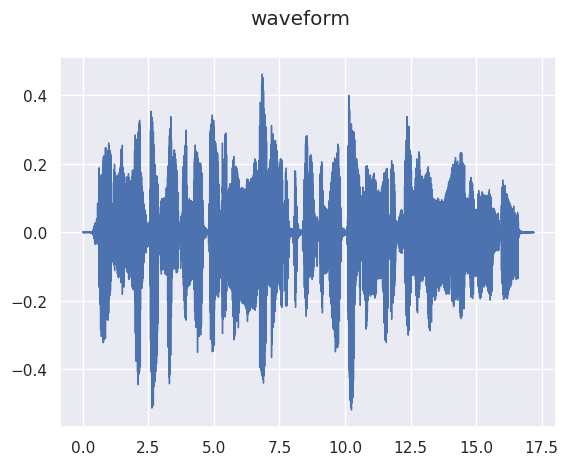

In [33]:
waveform, sample_rate = torchaudio.load(data["path_wav"][0])

def plot_waveform(waveform, sample_rate=16000):
    waveform = waveform.numpy()
    
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)
    
plot_waveform(waveform)

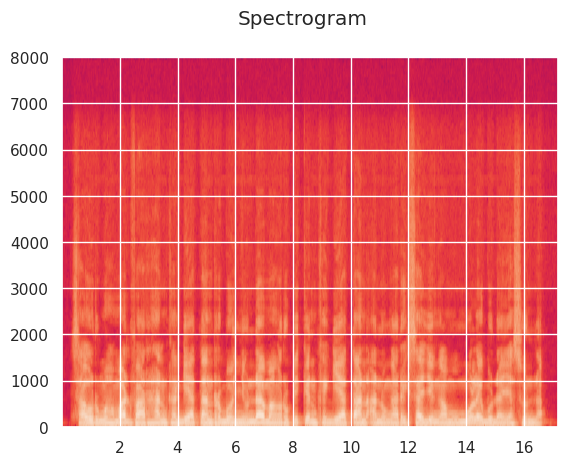

In [34]:
def plot_specgram(waveform, sample_rate=16000, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=True)
    
plot_specgram(waveform)

In [35]:
data_train, data_test = train_test_split(data, test_size=0.1)

print(f"Data training : {data_train.shape}\nData Test : {data_test.shape}")

Data training : (1630, 4)
Data Test : (182, 4)


In [36]:
dataset_train = Dataset.from_dict(data_train)
dataset_test = Dataset.from_dict(data_test)
dataset = datasets.DatasetDict({"train": dataset_train, "test": dataset_test})
dataset

DatasetDict({
    train: Dataset({
        features: ['path_wav', 'text', 'array', 'sample_rate'],
        num_rows: 1630
    })
    test: Dataset({
        features: ['path_wav', 'text', 'array', 'sample_rate'],
        num_rows: 182
    })
})

In [37]:
checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [38]:
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [39]:
def prepare_dataset(example):

    proses = processor(
        text=example["text"],
        audio_target=example["array"],
        sampling_rate=16000,
        return_attention_mask=False,
    )

    # strip off the batch dimension
    proses["labels"] = proses["labels"][0]

    # use SpeechBrain to obtain x-vector
    proses["speaker_embeddings"] = create_speaker_embedding(example["array"])

    return proses

In [40]:
processed_example = prepare_dataset(dataset["train"][0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [41]:
processed_example["labels"]

array([[-3.0810916, -2.7926772, -3.1378758, ..., -4.158027 , -4.3270774,
        -4.2526493],
       [-2.820428 , -2.8280344, -3.0719724, ..., -4.174457 , -4.2923594,
        -4.23699  ],
       [-2.7948015, -2.880582 , -3.3654418, ..., -4.146344 , -4.2282825,
        -4.2710824],
       ...,
       [-3.034829 , -2.6734784, -2.9276948, ..., -4.1627064, -4.162883 ,
        -4.251321 ],
       [-3.029351 , -2.8950095, -3.274627 , ..., -4.074566 , -4.147954 ,
        -4.2652187],
       [-2.7669718, -2.9918053, -3.49407  , ..., -3.984556 , -3.998563 ,
        -4.4510384]], dtype=float32)

In [42]:
processed_example["speaker_embeddings"].shape

(512,)

In [43]:
processed_example["labels"]

array([[-3.0810916, -2.7926772, -3.1378758, ..., -4.158027 , -4.3270774,
        -4.2526493],
       [-2.820428 , -2.8280344, -3.0719724, ..., -4.174457 , -4.2923594,
        -4.23699  ],
       [-2.7948015, -2.880582 , -3.3654418, ..., -4.146344 , -4.2282825,
        -4.2710824],
       ...,
       [-3.034829 , -2.6734784, -2.9276948, ..., -4.1627064, -4.162883 ,
        -4.251321 ],
       [-3.029351 , -2.8950095, -3.274627 , ..., -4.074566 , -4.147954 ,
        -4.2652187],
       [-2.7669718, -2.9918053, -3.49407  , ..., -3.984556 , -3.998563 ,
        -4.4510384]], dtype=float32)

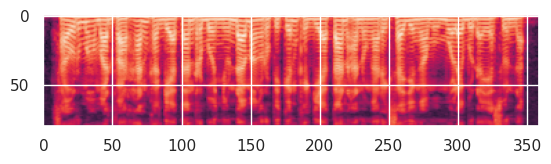

In [44]:
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [45]:
dataset["train"] = dataset["train"].map(prepare_dataset)
dataset["test"] = dataset["test"].map(prepare_dataset)

  0%|          | 0/1630 [00:00<?, ?ex/s]

  0%|          | 0/182 [00:00<?, ?ex/s]

In [46]:
dataset["train"], dataset["test"]

(Dataset({
     features: ['path_wav', 'text', 'array', 'sample_rate', 'input_ids', 'labels', 'speaker_embeddings'],
     num_rows: 1630
 }),
 Dataset({
     features: ['path_wav', 'text', 'array', 'sample_rate', 'input_ids', 'labels', 'speaker_embeddings'],
     num_rows: 182
 }))

In [47]:
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [48]:
data_collator = TTSDataCollatorWithPadding(processor=processor)
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [49]:
# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [50]:
training_args = Seq2SeqTrainingArguments(
    output_dir=f"text_to_speech_ind_sundanese",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [51]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trainer = Seq2SeqTrainer(                                                                    │
│   2 │   args=training_args,                                                                      │
│   3 │   model=model,                                                                             │
│   4 │   train_dataset=dataset["train"],                                                          │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer_seq2seq.py:56 in __init__           │
│                                                                                                  │
│    53 │   │   optimizers: Tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR] = (N   │
│    54 │   │   preprocess_logits_for_metrics: Optional[Callable[[torch.Tensor, torch.Tensor], t   │
│    55 │   ):                                                                                     │
│ ❱  56 │   │   super().__init__(                                                                  │
│    57 │   │   │   model=model,                                                                   │
│    58 │   │   │   args=args,                                                                     │
│    59 │   │   │   data_collator=data_collator,                                                   │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:563 in __init__                  │
│                                                                                                  │
│    560 │   │                                                                                     │
│    561 │   │   # Create clone of distant repo and output directory if needed                     │
│    562 │   │   if self.args.push_to_hub:                                                         │
│ ❱  563 │   │   │   self.init_git_repo(at_init=True)                                              │
│    564 │   │   │   # In case of pull, we need to make sure every process has the latest.         │
│    565 │   │   │   if is_torch_tpu_available():                                                  │
│    566 │   │   │   │   xm.rendezvous("init git repo")                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:3566 in init_git_repo            │
│                                                                                                  │
│   3563 │   │   else:                                                                             │
│   3564 │   │   │   repo_name = self.args.hub_model_id                                            │
│   3565 │   │   if "/" not in repo_name:                                                          │
│ ❱ 3566 │   │   │   repo_name = get_full_repo_name(repo_name, token=self.args.hub_token)          │
│   3567 │   │                                                                                     │
│   3568 │   │   # Make sure the repo exists.                                                      │
│   3569 │   │   create_repo(repo_name, token=self.args.hub_token, private=self.args.hub_private_  │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:828 in get_full_repo_name      │
│                                                            

In [ ]:
# trainer.train()

In [172]:
# trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/558M [00:00<?, ?B/s]

Upload file runs/Aug28_10-46-58_59fe2de0382b/events.out.tfevents.1693219630.59fe2de0382b.28.0:   0%|          …

To https://huggingface.co/hendrimardani/text_to_speech_ind_sundanese
   b665af1..b3f367a  main -> main

To https://huggingface.co/hendrimardani/text_to_speech_ind_sundanese
   b3f367a..bc787cd  main -> main



'https://huggingface.co/hendrimardani/text_to_speech_ind_sundanese/commit/b3f367ac2aeed20e32c86a06a583e1e082c9cd0e'

In [52]:
model = SpeechT5ForTextToSpeech.from_pretrained(
    "hendrimardani/text_to_speech_ind_sundanese"
)

In [55]:
example = dataset["test"][0]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [75]:
text = "bay bay bay bayb bay bay bay bay"
inputs = processor(text=text, return_tensors="pt")

In [76]:
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [78]:
Audio(speech.numpy(), rate=20000)